# MScFE 630 - Group 14 - Submission 1 Code - Qs 8, 9

## Inputs

In [21]:
#Market-specific inputs
r_f = 0.08

#Stock-specific inputs
S_0 = 100 
sigma_stock = 0.3

#Option-specific inputs
T = 1
months = 12*T
K = 100 #Option struck at-the-money
B = 150

#Counterparty-specific inputs
sigma_cp = 0.25
debt = 175 #Due in one year, same as the option's maturity
corr_stock_cp = 0.2
recovery_rate = 0.25
V_0 = 200

## Creating Empty Lists

In [22]:
#Ensure same set of pseudo-random numbers upon each code execution
import numpy as np
np.random.seed(0)

#Create empty arrays to store European UAO call and CVA mean value and standard error of mean for 50 sample sizes
european_uao_call_meanval = [None]*50
european_uao_call_stderror = [None]*50

cva_meanval = [None]*50
cva_stderror = [None]*50

default_adj_call_val = [None]*50
default_adj_call_val_stderror = [None]*50

## Functions

In [23]:
#Stock price path generator based on geometric Brownian motion
def stock_price_path(periods_per_path, current_stock_price, risk_free_rate, stock_vol, time_increment):
    
    series = np.zeros(periods_per_path)
    series[0] = current_stock_price
    
    for i in range(1, periods_per_path):        
        dWt = np.random.normal(0, 1) * np.sqrt(time_increment) #Brownian motion
        series[i] = series[i-1] * np.exp((risk_free_rate - stock_vol**2/2)*time_increment + stock_vol*dWt)

    return series

In [24]:
#Discounted vanilla call payoff
def discounted_call_payoff(terminal_stock_price, strike, risk_free_rate, time_to_maturity):
    return np.exp(-risk_free_rate*time_to_maturity)*np.maximum(terminal_stock_price - strike, 0)

In [25]:
#Black scholes price of vanilla call option
def bs_call(current_stock_price, strike, time_to_maturity, risk_free_rate, volatility):
    
    from scipy import stats
    
    d1 = (np.log(current_stock_price/strike) + (risk_free_rate + volatility**2/2)*time_to_maturity)/(volatility*np.sqrt(time_to_maturity))
    d2 = d1 - volatility * np.sqrt(time_to_maturity)
    
    return current_stock_price * stats.norm.cdf(d1) - strike * np.exp(-risk_free_rate*time_to_maturity) * stats.norm.cdf(d2)

In [26]:
#Terminal stock price
def terminal_value(initial_stock_price, risk_free_rate, volatility, Z, time_to_maturity):
    return initial_stock_price * np.exp((risk_free_rate - volatility**2/2)*time_to_maturity 
                                        + volatility*np.sqrt(time_to_maturity)*Z)

In [27]:
#Vanilla call payoff
def call_payoff(terminal_stock_price, strike):
    return np.maximum(terminal_stock_price - strike, 0)

## Correlation Matrix

In [28]:
corr_matrix = np.array([[1, corr_stock_cp],[corr_stock_cp, 1]])

## Visualising 100 Stock Price Paths (As An Example)

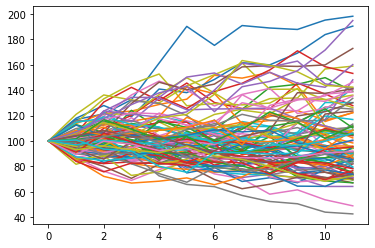

In [29]:
import matplotlib.pyplot as plt
paths_100 = []

for sample_path in range(0,100):
    plt.plot(stock_price_path(months, S_0, r_f, sigma_stock, T/months))

plt.show()    

## Monte Carlo Simulation

In [30]:
#Monte Carlo simulation
from scipy.stats import norm 

for simulation in range(1, 51):

    paths = simulation*1000
    all_paths = np.zeros([paths, months])
    
    #Call price estimate
    for i in range(0, paths):
        all_paths[i] = stock_price_path(months, S_0, r_f, sigma_stock, T/months)
        
    call_values = np.zeros([paths, 2])
    path_no = -1

    for path in all_paths:
        path_no += 1
        
        if sum((path >= B)) == 0:
            
            call_values[path_no, 0] = discounted_call_payoff(path[len(path)-1], K, r_f, T)
            call_values[path_no, 1] = 1
        
    european_uao_call_meanval[simulation-1] =  np.mean(np.extract(call_values[:, 1] == 1, call_values[:, 0]))
    european_uao_call_stderror[simulation-1] = np.std(np.extract(call_values[:, 1] == 1, call_values[:, 0])
                                                     ) / np.sqrt(np.sum(call_values[:, 1]))

    #CVA estimate
    norm_matrix = norm.rvs(size = np.array([2, paths]))
    corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)

    terminal_stock_val = terminal_value(S_0, r_f, sigma_stock, corr_norm_matrix[0, ], T)
    terminal_firm_val = terminal_value(V_0, r_f, sigma_cp, corr_norm_matrix[1, ], T)
    call_terminal_val = call_payoff(terminal_stock_val, K)
    
    amount_lost = np.exp(-r_f*T) * (1-recovery_rate) * (terminal_firm_val < debt) * call_terminal_val
    
    cva_meanval[simulation-1] = np.mean(amount_lost)
    cva_stderror[simulation-1] = np.std(amount_lost)/ np.sqrt(paths) 

    #Default-adjusted Call Value
    default_adj_call_val[simulation-1] = european_uao_call_meanval[simulation-1] - cva_meanval[simulation-1]
    default_adj_call_val_stderror[simulation-1] = np.sqrt((european_uao_call_stderror[simulation-1])**2 + 
                                                          (cva_stderror[simulation-1])**2)
    
    print('Running simulation', simulation, '...', 'Call Value:', european_uao_call_meanval[simulation-1].round(3), 
          'CVA:', cva_meanval[simulation-1].round(3), 'Default-adj Call Value:', 
          default_adj_call_val[simulation-1].round(3))

Running simulation 1 ... Call Value: 8.129 CVA: 1.741 Default-adj Call Value: 6.388
Running simulation 2 ... Call Value: 7.517 CVA: 1.966 Default-adj Call Value: 5.551
Running simulation 3 ... Call Value: 8.083 CVA: 2.052 Default-adj Call Value: 6.031
Running simulation 4 ... Call Value: 8.133 CVA: 1.786 Default-adj Call Value: 6.347
Running simulation 5 ... Call Value: 8.417 CVA: 2.058 Default-adj Call Value: 6.359
Running simulation 6 ... Call Value: 7.851 CVA: 1.885 Default-adj Call Value: 5.966
Running simulation 7 ... Call Value: 8.112 CVA: 1.797 Default-adj Call Value: 6.315
Running simulation 8 ... Call Value: 8.223 CVA: 1.796 Default-adj Call Value: 6.427
Running simulation 9 ... Call Value: 8.179 CVA: 1.948 Default-adj Call Value: 6.231
Running simulation 10 ... Call Value: 8.134 CVA: 1.897 Default-adj Call Value: 6.237
Running simulation 11 ... Call Value: 8.081 CVA: 1.854 Default-adj Call Value: 6.227
Running simulation 12 ... Call Value: 7.966 CVA: 1.943 Default-adj Call Va

## Table of Estimates

In [31]:
import pandas as pd
df = pd.DataFrame(list(zip(european_uao_call_meanval, cva_meanval, default_adj_call_val)), columns = ['Default-free UAO Call Value', 'CVA Estimate', 'Default-adjusted UAO Call Value'])
df.index.name = 'Simulation No.'
df.index += 1
df.round(3)

,Default-free UAO Call Value,CVA Estimate,Default-adjusted UAO Call Value
Simulation No.,,,
1,8.129,1.741,6.388
2,7.517,1.966,5.551
3,8.083,2.052,6.031
4,8.133,1.786,6.347
5,8.417,2.058,6.359
6,7.851,1.885,5.966
7,8.112,1.797,6.315
8,8.223,1.796,6.427
9,8.179,1.948,6.231


## Plot of Default-free European UAO Call Price Estimates

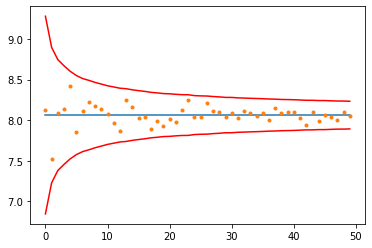

In [32]:
plt.plot([sum(european_uao_call_meanval)/len(european_uao_call_meanval)]*50)
plt.plot(european_uao_call_meanval, '.')
plt.plot(sum(european_uao_call_meanval)/len(european_uao_call_meanval) + 
         np.array(european_uao_call_stderror) * 3, 'r')
plt.plot(sum(european_uao_call_meanval)/len(european_uao_call_meanval) - 
         np.array(european_uao_call_stderror) * 3, 'r')
plt.show()

## Plot of CVA Estimates

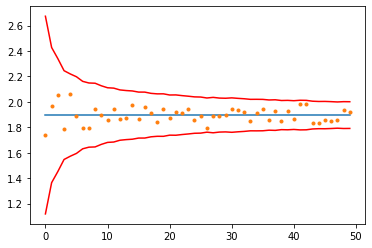

In [33]:
plt.plot([sum(cva_meanval)/len(cva_meanval)]*50)
plt.plot(cva_meanval, '.')
plt.plot(sum(cva_meanval)/len(cva_meanval) + np.array(cva_stderror) * 3, 'r')
plt.plot(sum(cva_meanval)/len(cva_meanval) - np.array(cva_stderror) * 3, 'r')
plt.show()

## Plot of Default-adjusted European UAO Call Price Estimates

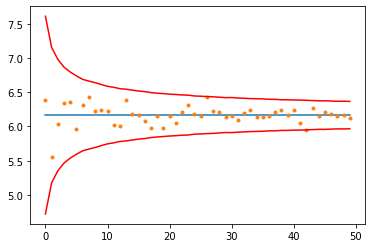

In [34]:
plt.plot([sum(default_adj_call_val)/len(default_adj_call_val)]*50)
plt.plot(default_adj_call_val, '.')
plt.plot(sum(default_adj_call_val)/len(default_adj_call_val) + np.array(default_adj_call_val_stderror) * 3, 'r')
plt.plot(sum(default_adj_call_val)/len(default_adj_call_val) - np.array(default_adj_call_val_stderror) * 3, 'r')
plt.show()